In [1]:
import json
import random
from dataclasses import dataclass, asdict
import os
import shutil
import numpy as np
import cv2
from observer import CalibratedObserver, CameraChange, TrackedObject, MiniMapObject, CalibratedCaptureConfiguration, Transition, distanceFormula
import dma.MechaCombat as mc

In [2]:
MM_TO_INCHES =  0.03937008
INCHES_TO_MM = 25.4

In [3]:
def numpy_serializer(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Type {type(obj)} not serializable")
    
def numpyizeDeserializedCameraChange(deserializedCameraChange: dict):
    if deserializedCameraChange['camName'] is not None:
        deserializedCameraChange['changeContours'] = [np.array(contour, dtype=np.int32) for contour in deserializedCameraChange['changeContours']]
        deserializedCameraChange['after'] = np.array(deserializedCameraChange['after'], dtype=np.int32)
        deserializedCameraChange['before'] = np.array(deserializedCameraChange['before'], dtype=np.int32)
        deserializedCameraChange['lastChange'] = numpyizeDeserializedCameraChange(deserializedCameraChange['lastChange'])
    return CameraChange(**deserializedCameraChange)

In [4]:
@dataclass
class HarmonyObject(TrackedObject):
    oid: str = None
    objectType: str = None
    objectSubType: str = None
    objectKwargs: dict = None

    objectFactories = {"Unit": mc.MechFactories, "Structure": mc.StructureFactories, "Terrain": mc.TerrainFactories}
    
    def __post_init__(self):
        super().__post_init__()
        print(f"Creating {self.objectType} -- {self.objectSubType} -- {self.objectKwargs}")
        self.objectKwargs = {key.lower(): value for key, value in self.objectKwargs.items()}

    def construct(self):
        try:
            factory = self.objectFactories[self.objectType][self.objectSubType]
        except KeyError as ke:
            raise Exception(f"Unrecognized object type and subtype - {self.objectType}-{self.objectSubType}") from ke
        try:
            factory(self.oid, **self.objectKwargs)
        except Exception as e:
            raise Exception(f"Failed to instantiate {factory} object") from e
        mc.GameState.addObject(self.oid, self.objectType)

    @classmethod
    def from_tracked_object(cls,
                            trackedObject: TrackedObject,
                            objectType: str,
                            objectSubType: str,
                            objectKwargs: dict):
        print(f"Creating {objectType} object from {trackedObject}")
        harmonyObject = cls(
            changeSet=trackedObject.changeSet,
            oid=trackedObject.oid,
            objectType=objectType,
            objectSubType=objectSubType,
            objectKwargs=objectKwargs)
        harmonyObject.construct()
        return harmonyObject
        
    def previousVersion(self):
        return TrackedObject({camName: change.lastChange if change is not None else None for camName, change in self.changeSet.items()})

    def rename(self, newName):
        mc.qs.rename_entity(self.oid, newName)
        self.oid = newName

In [5]:
@dataclass
class ObjectAction:
    actor: HarmonyObject
    target: HarmonyObject
    result: str = "null"
    
    def __post_init__(self):
        assert self.rsc is not None, f"Object Actions require a RealSpace Converter"
        if self.target is None:
            self.targetDistance = None
            self.targetRange = None
            self.rangeModifier = None
            self.objMovement = None
            self.aMM = None
            self.targetMovement = None
            self.tMM = None
            self.skill = None
            self.targetNumber = None
            self.gameEvent = None
            return
        # TODO: get distance from graph XY, Elevation instead
        self.targetDistance = self.rsc.distanceBetweenObjects(self.actor, self.target)
        self.targetRange = "short" if self.targetDistance < 155 else "medium" if self.targetDistance < 610 else "long"
        match self.targetRange:
            case "short":
                weaponSystems = mc.ShortRangeWeapons
            case "medium":
                weaponSystems = mc.MidRangeWeapons
            case "long":
                weaponSystems = mc.LongRangeWeapons
        self.rangeModifier = weaponSystems(self.actor.oid).Targeting.Modifier.terminant

        self.objMovement = self.rsc.trackedObjectLastDistance(self.actor)
        self.aMM = -1 if self.objMovement is None or self.objMovement < 10 else 1
        self.targetMovement = self.rsc.trackedObjectLastDistance(self.target)
        self.tMM = -1 if self.targetMovement is None or self.targetMovement < 10 else mc.TMM(self.actor.oid).terminant
        self.skill = mc.Skill(self.actor.oid).terminant
        self.otherModifiers = 0
        self.targetNumber = int(self.skill) + self.aMM + self.tMM + self.otherModifiers + self.rangeModifier
        self.gameEvent = None

    def declare(self):
        self.gameEvent = mc.GameEvent.declare_event("Attack", mc.Faction(self.actor.oid).terminant, self.actor.oid, self.target.oid, self.targetNumber, self.result)

    def resolve(self, result):
        self.gameEvent.resolve(result)

    def rename(self, entity, newEntity):
        start_nodes = self.get(start_node=entity)
        for node in start_nodes:
            self.drop(*node)
            self.put(newEntity, node[1], node[2])
            
        end_nodes = self.get(end_node=entity)
        for node in end_nodes:
            self.drop(*node)
            self.put(node[0], node[1], newEntity)

In [6]:
class HarmonyDB(mc.Graph):
    def reset(self, database_file=None):
        with self.DB_LOCK:
            for p in ["harmony.db", "harmony.db-shm", "harmony.db-wal"]:
                try:
                    os.remove(p)
                except FileNotFoundError:
                    pass

            if database_file is not None:
                shutil.copyfile(database_file, "harmony.db")
                self.conn = None
            else:
                with self.cursor() as cur:
                    cur.execute("DROP TABLE IF EXISTS edges;")
                    cur.execute("DROP TABLE IF EXISTS harmony_objects;")
                    cur.execute("""CREATE TABLE edges (
                        start_node TEXT NOT NULL,
                        edge_name TEXT NOT NULL,
                        end_node TEXT NOT NULL,
                        UNIQUE(start_node, edge_name) ON CONFLICT REPLACE);""")
                    cur.execute("""CREATE TABLE harmony_objects (
                        oid TEXT NOT NULL,
                        serialized_harmony_object TEXT NOT NULL,
                        UNIQUE(oid) ON CONFLICT REPLACE);""")
                    self.conn.commit()
                    cur.execute("PRAGMA synchronous=NORMAL")
                    cur.execute("PRAGMA journal_mode=WAL")

    def memorize(self, hObj: HarmonyObject):
        print(f"Memorizing: {hObj.oid}")
        with self.DB_LOCK, self.cursor() as cur:
            serializedHarmonyObject = json.dumps(asdict(hObj), default=numpy_serializer)
            cur.execute(f"INSERT INTO harmony_objects VALUES ('{hObj.oid}', '{serializedHarmonyObject}')")

    def raw_memories(self):
        with self.DB_LOCK, self.cursor() as cur:
            results = cur.execute("SELECT * FROM harmony_objects").fetchall()
        return results
    
    def remember(self):
        raw_memories = self.raw_memories()
        memory = []
        for r in raw_memories:
            mem = json.loads(r[1])
            for cam, cameraChange in mem['changeSet'].items():
                mem['changeSet'][cam] = numpyizeDeserializedCameraChange(cameraChange)
            memory.append(mem)
        return memory

    def rename(self, entity, newEntity):
        super().rename(entity, newEntity)
        with self.DB_LOCK, self.cursor() as cur:
            mem = list(cur.execute(f"SELECT * FROM harmony_objects WHERE oid='{entity}'").fetchall()[0])
            mem[0] = newEntity
            deserializedMem = json.loads(mem[1])
            deserializedMem['oid'] = newEntity
            mem[1] = json.dumps(deserializedMem)
            mem_values = ", ".join([f"'{v}'" for v in mem])
            cur.execute(f"DELETE FROM harmony_objects WHERE oid='{entity}';")
            cur.execute(f"INSERT INTO harmony_objects VALUES ({mem_values});")
        
    def saveGame(self, gameName="harmony"):
        shutil.copyfile("harmony.db", f"{gameName}.harmony")
        
    def loadGame(self, gameName="harmony"):
        self.reset(database_file=f"{gameName}.harmony")

mc.qs.graph = HarmonyDB()

In [11]:
@dataclass()
class HarmonyMachine(CalibratedObserver):
    cc: CalibratedCaptureConfiguration

    def __post_init__(self):
        self.reset()
        self.GameState = mc.GameState
        self.GameEvents = mc.GameEvents

    def getPhase(self):
        return mc.GameState.getPhase()

    def getRoundCount(self):
        return mc.GameState.getRoundCount()

    def reset(self, database_file=None):
        CalibratedObserver.reset(self)
        ObjectAction.rsc = self.cc.rsc
        mc.GameState.reset()

    def __repr__(self):
        return f"HarmonyMachine -- Cycle: {self.cycleCounter:5} -- Objects: {len(self.memory):5} -- {mc.GameState.getPhase():6} -- {self.mode}|{self.state}"
    
    def cycleStatus(self):
        return f"{self}"
    
    def classifyObject(self, objectId: str, objectType: str, objectSubType:str , objectKwargs: dict):
        trackedObject = self.findObject(objectId)
        memoryIndex = self.memory.index(trackedObject)
        harmonyObject = HarmonyObject.from_tracked_object(
            trackedObject, objectType, objectSubType, objectKwargs)
        mc.XYLocation.set_relationship(harmonyObject.oid, self.cc.rsc.changeSetToRealCenter(harmonyObject))
        self.memory[memoryIndex] = harmonyObject
        mc.qs.graph.memorize(harmonyObject)
        return harmonyObject

    def captureRealCoord(self, capture):
        """ movement distance this round """
        return [*self.cc.rsc.changeSetToRealCenter(capture), self.objectElevation(capture)]

    def captureSystemCoord(self, capture):
        return [*mc.XYLocation(capture.oid).terminant, mc.Elevation(capture.oid).terminant]

    def commitChanges(self, objDef, overwrite=True):
        try:
            existingIndex = self.memory.index(objDef.previousVersion())
            print(f"Updating Memory {objDef.oid}")
            self.memory[existingIndex].update(objDef, overwrite=overwrite)
        except ValueError:
            print(f"New Memory")
            if mc.GameState.getPhase() != "Add":
                raise Exception("Cannot make new memories outside of Add Phase")
            self.memory.append(objDef)
            existingIndex = len(self.memory) - 1
        self.lastMemory = objDef
        
        self.transitions.append(Transition(
            objDef,
            self.cycleCounter,
            {camName: {"ref": cam.referenceFrame, "fin": cam.mostRecentFrame}
             for camName, cam in self.cc.cameras.items()}))
    
        if isinstance(objDef, HarmonyObject):
            systemCoord = self.captureSystemCoord(objDef)
            realCoord = self.captureRealCord(objDef)
            delta = [d1 - d0 for d0, d1 in zip(systemCoord, realCoord)]
            if mc.Move.can_move(objDef, delta):
                self.declareEvent(
                    eventType="Move",
                    eventFaction=mc.Faction(objDef.oid),
                    eventObject=objDef.oid,
                    eventValue=json.dumps(delta),
                    eventTarget=mc.MovementSpeed(objDef.oid).terminant,
                    eventResult=json.dumps(realCoord))
            else:
                raise Exception(f"{objDef.oid} cannot move {delta}")

            mc.qs.graph.memorize(objDef)
        return objDef

    def takeAction(self, actor, target, result=None):
        return ObjectAction(actor, target, result=result)

    def objectLocation(self, harmonyObject):
        if mc.GameState.getPhase() == "Move":
            return self.captureRealCoord(harmonyObject)
        else:
            return [*mc.XYLocation(harmonyObject.oid).terminant, mc.Elevation(harmonyObject.oid).terminant]

    def distanceFromRealPoint(self, harmonyObject: HarmonyObject, realPoint: (float, float, float)):
        objectPoint = [*mc.XYLocation(harmonyObject.oid).terminant, mc.Elevation(harmonyObject.oid).terminant]
        distance = (distanceFormula(objectPoint[:2], realPoint[:2]) + abs(realPoint[2] - objectPoint[2]) * 2) * MM_TO_INCHES
        return distance

    def objectLastDistance(self, harmonyObject: HarmonyObject):
        if mc.GameState.getPhase() == "Move":
            currentPoint = self.captureRealCoord(harmonyObject)
            lastDistance = self.distanceFromRealPoint(harmonyObject, currentPoint)
            return lastDistance
        else:
            return mc.DistanceMoved(harmonyObject.oid).terminant

    def objectCanMove(self, harmonyObject: HarmonyObject):
        return harmonyObject.oid in mc.Move.entities()

    def objectCanAct(self, harmonyObject: HarmonyObject):
        return harmonyObject.oid in mc.Weapons.entities()
        
    def objectHasMoved(self, harmonyObject: HarmonyObject):
        if self.objectLastDistance(harmonyObject) > 0.3:
            return True
        return False

    def unitsMovedThisRound(self):
        mechs = self.active_units()
        moved = []
        for m in mechs:
            harmonyObject = self.findObject(m)
            if self.objectHasMoved(harmonyObject):
                moved.append(m)
        return moved

    def declareEvent(cls, eventType: str, eventFaction: str, eventObject: str, eventValue: str, eventTarget: float, eventResult: str):
        print(f"{eventObject} declaring event {eventType}")
        mc.GameState.declareEvent(
            eventType=eventType, eventFaction=eventFaction, eventObject=eventObject, eventValue=eventValue,
            eventTarget=eventTarget, eventResult=eventResult)

    def objectHasDeclared(self, harmonyObject):
        if len(mc.GameEvents.get_existing_declarations(harmonyObject.oid)) > 0:
            return True
        return False

    def unitsDeclaredThisRound(self):
        mechs = mc.Mech.entities()
        declared = []
        for m in mechs:
            harmonyObject = self.findObject(m)
            if self.objectHasDeclared(harmonyObject):
                declared.append(m)
        return declared

    def objectHasResolved(self, harmonyObject):
        for re in mc.GameEvents.get_resolved_events():
            if harmonyObject.oid == re.GameEventObject.terminant:
                return True
        return False

    def actionsToResolve(self):
        declared_actions = len(self.unitsDeclaredThisRound())
        no_actions = len(mc.GameEvents.get_declared_no_action_events())
        return declared_actions - no_actions

    def commitAdditions(self):
        for entity in mc.XYLocation.entities():
            harmonyObject = self.findObject(entity)
            mc.XYLocation(entity, self.captureRealCoord(harmonyObject)[:2])
        mc.GameState.newPhase("Add")

    def commitMovement(self):
        self.passiveMode()
        for entity in mc.Movement.entities():
            obj = self.findObject(entity)
            if self.objectHasMoved(obj):
                elevation = self.objectElevation(obj)
                mc.Move.move_to(entity=entity, newLocation=[*self.cc.rsc.changeSetToRealCenter(obj), elevation])
        mc.GameState.newPhase("Move")

    def resolveRound(self):
        for entity in mc.Movement.entities():
            mc.DistanceMoved.set_relationship(entity, 0)
        mc.GameState.newPhase("Action")
        self.trackMode()

    def units(self):
        return mc.Mech.entities()

    def active_units(self):
        return mc.Mech.active_mechs()

    def obj_destroyed(self, oid: str):
        return mc.UnitDamage.is_destroyed(entity=oid)

    def mech_skill(self, mech_oid: str):
        return mc.Skill(mech_oid).terminant

    def factions(self):
        return mc.Faction.terminants()

    def faction(self, oid: str):
        return mc.Faction(oid).terminant

    def object_type(self, oid: str):
        return mc.GameObject(oid).terminant

    def line_of_sight(self, actor: HarmonyObject, target: HarmonyObject):
        actorPersp = [*mc.XYLocation(actor.oid).terminant, mc.Elevation(actor.oid).terminant]
        targetPersp = [*mc.XYLocation(target.oid).terminant, mc.Elevation(target.oid).terminant]

        perspElevation = max(actorPersp[2], targetPersp[2])
        visualObstacles = [m for m in self.memory if mc.Elevation(m.oid).terminant >= perspElevation]

        return self.cc.line_of_sight(actor, target, visualObstacles)

    def can_target(self, actor: HarmonyObject, target: HarmonyObject):
        return target.oid != actor.oid and \
            self.object_type(target.oid) in ["Unit", "Structure"] and \
            self.faction(actor.oid) != self.faction(target.oid) and \
            self.line_of_sight(actor, target)

    @property
    def objectsAndColors(self):
        factions = self.factions()
        factionColors = {faction: color for faction, color in zip(factions, self.distinct_colors(len(factions)))}
        factionColors["Unaligned"] = (255, 0, 0)
        return [
            MiniMapObject(
                mem,
                factionColors[self.faction(mem.oid)]
            ) for mem in self.memory]

    def changeOverlaps(self, camera, change):
        changes = [m.changeSet[camera.camName] for m in self.memory if self.object_type(m.oid) in [None, "Unit"]]
        overlaps = []
        for eC in changes:
            if eC.changeType is not None and eC.changeOverlap(change) and eC not in overlaps:
                overlaps.append(eC)
        return overlaps

    def objectElevation(self, obj):
        terrainAndBuildings = [m for m in self.memory if self.object_type(m.oid) in ["Terrain", "Structure"]]
        overlaps = []
        for cam, changeSet in obj.changeSet.items():
            for tOrB in terrainAndBuildings:
                tOrBChangeSet = tOrB.changeSet[cam]
                if tOrBChangeSet is not None and tOrBChangeSet.changeOverlap(changeSet):
                    if tOrB not in overlaps:
                        overlaps.append(tOrB)
        if overlaps:
            return mc.Elevation(overlaps[0].oid).terminant + 1
        else:
            return 1
        
    def saveGame(self, gameName="harmony"):
        mc.qs.graph.saveGame(gameName=gameName)
        
    def loadGame(self, gameName="harmony"):
        self.reset()
        mc.qs.graph.loadGame(gameName=gameName)
        self.memory = [HarmonyObject(**mem) for mem in mc.qs.graph.remember()]

    @staticmethod
    def contrast_color(bg=(139, 69, 19)):  # Brown background
        """ Generate a color with good contrast against a given background. """

    def distinct_colors(self, n=15):
        """ Generate n distinct colors that stand out against brown. """
        if n > 1 and len(getattr(self, "_colors", [])) == n:
            return self._colors
        colors = set()
        contrast_colors = [(139, 69, 19), (204, 100, 2), (0, 255, 0)]
        calc_contrast = lambda r, g, b, bg: abs(r - bg[0]) + abs(g - bg[1]) + abs(b - bg[2])
        while len(colors) < n:
            color = None
            for i in range(100):
                r, g, b = (random.randint(50, 230) for _ in range(3))  # Exclude near black/white
                contrasts = [calc_contrast(r, g, b, c) for c in contrast_colors + list(colors)]
                if sum([contrast > 200 for contrast in contrasts]) >= len(contrast_colors + list(colors)):  # Ensure high contrast
                    color = (r, g, b)
                    break
            if color is None:
                raise Exception(f"Failed to generate color within 100 cycles")
            colors.add((r, g, b))
        self._colors = list(colors)
        return self._colors
    
    def getCameraImagesWithChanges(self, cameraKeys=None, show_interactions=True):
        if cameraKeys is None:
            cameraKeys = self.cc.cameras.keys()

        images = {}
        for camName in cameraKeys:
            cam = self.cc.cameras[camName]
            camImage = cam.cropToActiveZone(cam.mostRecentFrame.copy())
            # Paint last changes red
            if self.lastChanges is not None and not self.lastChanges.empty:
                lastChange = self.lastChanges.changeSet[camName]
                if lastChange is not None and lastChange.changeType not in ['delete', None]:
                    lastChangeContour = np.array([lastChange.changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, lastChangeContour, -1 , (0, 0, 127), -1)
            # Paint classification green
            if self.lastClassification is not None and not self.lastClassification.empty:
                lastClass = self.lastClassification.changeSet[camName]
                if lastClass is not None and lastClass.changeType not in ['delete', None]:
                    lastClassContour = np.array([lastClass.changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, lastClassContour, -1 , (0, 255, 0), -1)
            
            # Paint known objects faction color
            for objAndColor in self.objectsAndColors:
                memObj = objAndColor.object
                color = objAndColor.color
                if memObj.changeSet[camName].changeType not in ['delete', None]:
                    memContour = np.array([memObj.changeSet[camName].changePoints], dtype=np.int32)
                    camImage = cv2.drawContours(camImage, memContour, -1, color, -1)
                    if show_interactions and self.objectCouldInteract(memObj):
                        center_x = int(np.mean(memContour[:, :, 0]))  # Mean of x-coordinates
                        center_y = int(np.mean(memContour[:, :, 1]))  # Mean of y-coordinates
                        camImage = cv2.circle(camImage, (center_x, center_y), radius=10, color=(0, 255, 0), thickness=-1)
                    
            camImage = cv2.resize(camImage, [480, 640], interpolation=cv2.INTER_AREA)
            images[camName] = camImage
        return images

    def objectCouldInteract(self, obj: TrackedObject):
        match self.getPhase():
            case "Move":
                canMove = self.objectCanMove(obj) and not self.objectHasMoved(obj)
                return canMove
            case "Declare":
                return self.objectCanAct(obj) and not self.objectHasDeclared(obj)
            case "Action":
                return self.objectCanAct(obj) and not self.objectHasResolved(obj)

    def buildMiniMap(self, objectsAndColors=None, showInteractions=True):
        miniMap = super().buildMiniMap(objectsAndColors=objectsAndColors)
        
        x, y, w, h = self.cc.realSpaceBoundingBox()

        if showInteractions:
            for memObj in self.memory:
                if self.objectCouldInteract(memObj):
                    hull = self.cc.objectToHull(memObj)
                    center_x = int(np.mean(hull[:, :, 0]) - x)  # Mean of x-coordinates
                    center_y = int(np.mean(hull[:, :, 1]) - y)  # Mean of y-coordinates
                    print(center_x, center_y)
                    miniMap = cv2.circle(miniMap, (center_x, center_y), radius=10, color=(0, 255, 0), thickness=-1)
        return miniMap

    def shift_hull_within_bounds(self, hull, shift, image_shape):
        """
        Shifts a convex hull by a given (x, y) shift while ensuring it stays within image bounds.
    
        :param hull: The convex hull (NumPy array of shape (N, 1, 2)).
        :param shift: The shift vector (x, y) as a NumPy array.
        :param image_shape: Shape of the image (height, width).
        :return: Shifted convex hull within bounds.
        """
        height, width = image_shape[:2]
    
        # Shift the hull points
        shifted_hull = hull + shift
    
        # Ensure all points remain within bounds
        shifted_hull[:, :, 0] = np.clip(shifted_hull[:, :, 0], 0, width - 1)   # Clip X values
        shifted_hull[:, :, 1] = np.clip(shifted_hull[:, :, 1], 0, height - 1)  # Clip Y values
        return shifted_hull
    
    def buildMovementHeatMap(self, harmonyObject: HarmonyObject):
        hull = self.cc.objectToHull(harmonyObject)

        movement_speed = mc.MovementSpeed(harmonyObject.oid).terminant
        generate_ds = lambda: [[1, 0], [1, 0.5], [1, 1], [0.5, 1], [0, 1], [-0.5, 1], [-1, 1], [-1, 0.5], [-1, 0], [-1, -0.5], [-1, -1], [-0.5, -1], [0, -1], [0.5, -1], [1, -1]]
        path_blocked = {tuple(path): False for path in generate_ds()}
        costByLocation = {}
        near_moves = []
        med_moves = []
        long_moves = []
        full_moves = []
        for dx, dy in generate_ds():
            for i in range(1, 20, 2):
                i = i * 0.3
                if path_blocked[(dx, dy)]:
                    continue
                x, y = dx * i, dy * i
                elevation = 1
                # Find Object overlaps at x, y position
                # Elevation = 1 or elevation(overlaps[0]) + 1
                zeros = np.zeros([1200, 1200, 3], dtype="uint8")
                shiftedHull= self.shift_hull_within_bounds(hull, np.array([x * INCHES_TO_MM, y * INCHES_TO_MM], dtype=np.int32), zeros.shape)
                shiftedIm = cv2.drawContours(zeros.copy(), [shiftedHull], -1, 255, -1)
                for obj in self.memory:
                    if obj.oid == harmonyObject.oid:
                        continue
                    objHull = self.cc.objectToHull(obj)
                    changeIm = cv2.drawContours(zeros.copy(), [objHull], -1, 255, -1)
                    overlap = cv2.bitwise_and(changeIm, shiftedIm)
                    if overlap.any():
                        if self.object_type(obj.oid) in ["Terrain", "Structure"]:
                            elevation = mc.Elevation(obj.oid).terminant + 1
                        elif self.object_type(obj.oid) in ["Unit"]:
                            print(f"{dx}, {dy} is blocked")
                            path_blocked[(dx, dy)] = True
                            break
        
                movement_cost = mc.Move.movement_cost([dx * i * INCHES_TO_MM, dy * i * INCHES_TO_MM, elevation * INCHES_TO_MM])

                if movement_cost >= movement_speed * 0.95:
                    path_blocked[(dx, dy)] = True
                else:
                    costByLocation[(x, y)] = movement_cost
                    if movement_cost < movement_speed * 0.2:
                        near_moves.append((x, y))
                    elif movement_cost < movement_speed * 0.5:
                        med_moves.append((x, y))
                    elif movement_cost < movement_speed * 0.7:
                        long_moves.append((x, y))
                    else:
                        full_moves.append((x, y))

        layer_hulls = []
        for moves, color in zip([near_moves, med_moves, long_moves, full_moves], [(0, 255, 0), (0, 255, 125), (0, 125, 255), (0, 0, 255)]):
            if len(moves) == 0:
                continue
            image = np.zeros([1200, 1200, 1], dtype="uint8")
            move_hulls = [hull + np.array([x * INCHES_TO_MM, y * INCHES_TO_MM], dtype=np.int32) for x, y in moves]
            move_hull = cv2.convexHull(np.vstack(move_hulls))
            layer_hulls.append((move_hull, color))

        image = np.zeros([1200, 1200, 3], dtype="uint8")
        for layer_hull, color in layer_hulls[::-1]:
            image = cv2.drawContours(image, [layer_hull], -1, color, -1)

        return image

    def buildMovementMap(self, harmonyObject: HarmonyObject):
        image = np.zeros([1200, 1200, 3], dtype="uint32")
        if self.cc.rsc is None:
            return image
        
        x, y, w, h = self.cc.realSpaceBoundingBox()
        
        minimap = self.buildMiniMap(
            objectsAndColors=[MiniMapObject(mem, (0, 255, 0) if mem.oid == harmonyObject.oid else (0, 0, 255) if self.object_type(mem.oid) == "Unit" else (255, 0, 0)) for mem in self.memory],
            showInteractions=False)
        heatMap = self.buildMovementHeatMap(harmonyObject)[y:y+h, x:x+w]
    
        # Blend the original image with the overlay using `alpha`
        alpha = 0.4
        return cv2.addWeighted(heatMap, alpha, minimap, 1 - alpha, 0)

    def buildVisibilityMap(self, harmonyObject: HarmonyObject):
        if self.cc.rsc is None:
            return image
        
        x, y, w, h = self.cc.realSpaceBoundingBox()

        hull = self.cc.objectToHull(harmonyObject)
        center = [int(d) for d in mc.XYLocation(harmonyObject.oid).terminant]

        def select_color(mem):
            if mem.oid == harmonyObject.oid:
                return (0, 255, 0) 
            elif self.object_type(mem.oid) == "Unit":
                if self.faction(harmonyObject.oid) != self.faction(mem.oid):
                    return (0, 0, 255) 
                else:
                    return (125, 255, 0)
            else:
                return (255, 0, 0)
        
        minimap = self.buildMiniMap(
            objectsAndColors=[MiniMapObject(mem, select_color(mem)) for mem in self.memory],
            showInteractions=False)

        image = np.zeros([1200, 1200, 3], dtype="uint8")
        for radius, color in zip([42 * INCHES_TO_MM, 24 * INCHES_TO_MM, 6 * INCHES_TO_MM], [(0, 0, 255), (0, 125, 255), (0, 255, 0)]):
            cv2.circle(image, center, int(radius), color, -1)

        for target in self.memory:
            if self.can_target(harmonyObject, target):
                cv2.line(image, center, [int(d) for d in mc.XYLocation(target.oid).terminant], color=(0, 0, 0), thickness=2)

        image = image[y:y+h, x:x+w]

        alpha = 0.2
        image = cv2.addWeighted(image, alpha, minimap, 1 - alpha, 0)
                
        return image

Starting Cycle HarmonyMachine -- Cycle:     0 -- Objects:     0 -- Add    -- passive|idle


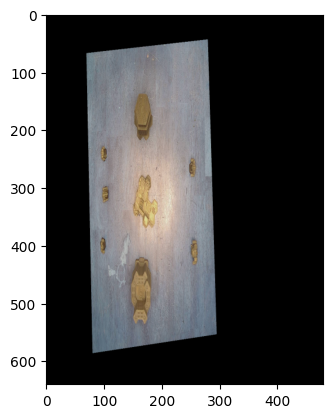

In [12]:
if __name__ == "__main__":
    from matplotlib import pyplot as plt
    cc = CalibratedCaptureConfiguration()
    hm = HarmonyMachine(cc=cc)
    hm.cycle()
    plt.imshow(hm.getCameraImagesWithChanges()['0'])

In [ ]:
if __name__ == "__main__":
    for i in range(3):
        hm.cycleForChange()
    for i in range(3):
        hm.cycle()

    hm.classifyObject(hm.memory[0].oid, objectType="Unit", objectSubType="Kingfisher Prime", objectKwargs={"Faction": "Foo", "Skill": 4})
    hm.memory[0].rename("Gypsy Danger")
    hm.classifyObject(hm.memory[1].oid, objectType="Unit", objectSubType="Atlas", objectKwargs={"Faction": "Bar", "Skill": 4})
    hm.memory[1].rename("Cherno")
    plt.imshow(hm.getCameraImagesWithChanges()['0'])

In [ ]:
if __name__ == "__main__":
    from IPython.display import display 
    print(f"Saving game with {len(hm.memory)} memories")
    hm.saveGame()

In [ ]:
if __name__ == "__main__":
    hm.reset()
    print("Reset Game Engine:")
    print("\n".join([f"{m}" for m in hm.memory]))
    plt.imshow(hm.getCameraImagesWithChanges()['0'])
    plt.show()
    display(mc.qs.render())
    print("Loading game...")
    hm.loadGame()
    print("Reloaded Game Engine:")
    print("\n".join([f"{m}" for m in hm.memory]))
    plt.imshow(hm.getCameraImagesWithChanges()['0'])
    plt.show()
    display(mc.qs.render())